In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
#required packages.
import numpy as np
import pandas as pd
from pandas import Timestamp
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
import datetime
import itertools
import argparse
import collections

Prior to using the Earth Engine Python client library, you need to authenticate (verify your identity) and use the resultant credentials to initialize the Python client. The authentication flows use Cloud Projects to authenticate, and they're used for unpaid (free, noncommercial) use as well as paid use. To authenticate and initialize, run the following codes.

https://developers.google.com/earth-engine/guides/auth


In [2]:
import ee
# # Trigger the authentication flow.
ee.Authenticate()
# Initialize the library.
ee.Initialize()

## utils

In [ ]:
#must run these codes
def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

def ee_array_to_df1(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors="coerce")

    # Convert the time field into a datetime.
    df["datetime"] = pd.to_datetime(df["time"], unit="ms")

    # Keep the columns of interest.
    df = df[["time", "datetime", *list_of_bands]]

    # The datetime column is defined as index.
    df = df.set_index("datetime")

    return df

## landsat point downloading

In [ ]:
def get_cloud_mask(image):
    # This function masks cloudy pixels.
    # Computes a simple cloud-likelihood score in the range [0,100] using a combination of brightness, temperature, and NDSI.
    # This is not a robust cloud detector, and is intended mainly to compare multiple looks at the same point for relative cloud likelihood.
    clouds = (ee.Algorithms.Landsat.simpleCloudScore(image).select(['cloud']))
    cloudMask = image.updateMask(clouds.lt(20))
    return cloudMask

def get_landsat_image(r_lon, r_lat, scale, selected_features, i_date, f_date):
  #Define the location of interest with a point.
  # https://developers.google.com/earth-engine/guides/landsat
  poi = ee.Geometry.Point(r_lon, r_lat)
  #collect landsat images
  land8 = (ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA')
              .filterBounds(poi)
              .filterDate(i_date, f_date)
              .select(selected_features)
              .map(get_cloud_mask)
              .median())

  #get the metadata of the band
  s2_band_vals = land8.sample(poi, scale).first().getInfo()
  #reorder the band values referencing selected_bands
  df = pd.DataFrame(s2_band_vals['properties'], index=['i',])
  df = df.reset_index(drop=True)

  return df

In [ ]:
i_date, f_date = '2015-01-01', '2015-12-31'
r_lon, r_lat = 142.4377389809555, -30.95203025969217
scale = 30
selected_features = ["B1","B2", "B3","B4", "B5", "B6","B7","B8", "B9","B10","B11"]

get_landsat_image(r_lon, r_lat, scale, selected_features, i_date, f_date)

,B1,B10,B11,B2,B3,B4,B5,B6,B7,B8,B9
0,0.137444,301.033783,299.355652,0.122349,0.12668,0.204242,0.291307,0.389584,0.307196,0.148894,0.001959


## landsat time series downloading

In [ ]:
# This function masks cloudy pixels.
def get_cloud_mask(image):
    clouds = (ee.Algorithms.Landsat.simpleCloudScore(image).select(['cloud']))
    cloudMask = image.updateMask(clouds.lt(20))
    return cloudMask

def collect_landsat_data(i_date, f_date, r_lon, r_lat, scale=30, selected_features=None):
    if selected_features is None:
        selected_features = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B9", "B10", "B11"]

    # Define the location of interest with a point
    poi = ee.Geometry.Point(r_lon, r_lat)

    # Collect Landsat images and apply cloud mask
    land8 = (ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA')
             .filterBounds(poi)
             .filterDate(i_date, f_date)
             .select(selected_features)
             .map(get_cloud_mask))

    # Evaluate local precipitation conditions
    local_pr = land8.getRegion(poi, scale).getInfo()

    return local_pr

In [ ]:
i_date, f_date = '2015-01-01', '2015-12-31'
r_lon, r_lat = 142.4377389809555, -30.95203025969217
scale = 30
selected_features = ["B1","B2", "B3","B4", "B5", "B6","B7","B8", "B9","B10","B11"]

local_pr = collect_landsat_data(i_date, f_date, r_lon, r_lat, scale, selected_features)

In [ ]:
# convert multitemporal array to pandas
pr_df = ee_array_to_df(local_pr, selected_features)
pr_df

,time,datetime,B1,B2,B3,B4,B5,B6,B7,B8,B9,B10,B11
1,1421885997798,2015-01-22 00:19:57.798,0.136769,0.122340,0.137817,0.225227,0.318946,0.429428,0.330018,0.161295,0.001595,306.725128,303.095490
2,1423268394585,2015-02-07 00:19:54.585,0.134966,0.120668,0.134303,0.212275,0.323289,0.418900,0.328030,0.155135,0.001990,311.635132,308.756439
4,1426033178228,2015-03-11 00:19:38.228,0.136194,0.122730,0.134853,0.210700,0.313959,0.406113,0.310472,0.156014,0.001582,309.822144,307.341187
5,1427415570032,2015-03-27 00:19:30.032,0.137328,0.124081,0.136043,0.214614,0.309317,0.403162,0.319538,0.158141,0.002227,299.975494,299.357056
7,1430180356992,2015-04-28 00:19:16.992,0.137968,0.122238,0.128503,0.203381,0.288870,0.381466,0.299143,0.148982,0.001886,292.178040,291.878174
8,1431562740816,2015-05-14 00:19:00.816,0.146146,0.128635,0.130519,0.199824,0.283610,0.373160,0.288524,0.148806,0.002106,288.296082,288.190521
9,1435709963346,2015-07-01 00:19:23.346,0.142052,0.120261,0.111390,0.159153,0.233357,0.308370,0.244530,0.124653,0.002516,283.047058,283.350525
10,1437092373715,2015-07-17 00:19:33.715,0.156774,0.134635,0.123791,0.183537,0.271971,0.371986,0.276063,0.146093,0.002251,281.544830,281.690033
11,1438474777376,2015-08-02 00:19:37.376,0.142121,0.123551,0.119935,0.174403,0.260889,0.343758,0.270607,0.134173,0.001431,287.555634,287.075684
12,1439857184179,2015-08-18 00:19:44.179,0.140144,0.121318,0.118948,0.179387,0.269216,0.359214,0.286992,0.135776,0.001896,291.587128,291.042664


In [ ]:
# This function masks cloudy pixels.
def get_cloud_mask(image):
    clouds = (ee.Algorithms.Landsat.simpleCloudScore(image).select(['cloud']))
    cloudMask = image.updateMask(clouds.lt(20))
    return cloudMask

#Define the location of interest with a point.
poi = ee.Geometry.Point(r_lon, r_lat)
#collect landsat images
land8 = (ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA')
            .filterBounds(poi)
            .filterDate(i_date, f_date)
            .select(selected_features)
            .map(get_cloud_mask))

# Evaluate local precipitation conditions.
local_pr = land8.getRegion(poi, scale).getInfo()
pr_df = ee_array_to_df(local_pr, selected_features)
pr_df

,time,datetime,B1,B2,B3,B4,B5,B6,B7,B8,B9,B10,B11
0,1420503603050,2015-01-06 00:20:03.050,0.599947,0.621206,0.633391,0.649614,0.716525,0.415971,0.260310,0.591383,0.003597,283.243530,283.528717
1,1421885997798,2015-01-22 00:19:57.798,0.136769,0.122340,0.137817,0.225227,0.318946,0.429428,0.330018,0.161295,0.001595,306.725128,303.095490
2,1423268394585,2015-02-07 00:19:54.585,0.134966,0.120668,0.134303,0.212275,0.323289,0.418900,0.328030,0.155135,0.001990,311.635132,308.756439
3,1424650788548,2015-02-23 00:19:48.548,0.247361,0.247361,0.234950,0.313037,0.464615,0.532003,0.389694,0.297308,0.035673,278.001587,267.390320
4,1426033178228,2015-03-11 00:19:38.228,0.136194,0.122730,0.134853,0.210700,0.313959,0.406113,0.310472,0.156014,0.001582,309.822144,307.341187
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,1444609571646,2015-10-12 00:26:11.646,0.132927,0.118799,0.124577,0.194163,0.272978,0.384530,0.301111,0.145855,0.005631,303.804962,302.318329
59,1445991976906,2015-10-28 00:26:16.906,0.129705,0.116352,0.126489,0.206721,0.287629,0.409388,0.328526,0.152122,0.002400,314.825989,312.637054
60,1447374376769,2015-11-13 00:26:16.769,0.129351,0.117355,0.128965,0.208993,0.295802,0.418939,0.332970,0.153434,0.002132,303.308868,301.365387
61,1448756780082,2015-11-29 00:26:20.082,0.135893,0.125119,0.139649,0.230919,0.313664,0.443057,0.365619,0.167223,0.005240,316.399719,313.309601


## landsat image downloading

### single band

In [10]:
def get_landsat_time_series_images(aoi_modis, target_band, i_date, f_date, scale):
    # Load a collection
    TERRA = (ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA')
              .select([target_band])
              .filterDate(i_date, f_date)
              .filterBounds(aoi_modis)  # Add this line to filter images containing AOI
              .sort('system:time_start'))

    # Extract an image
    TERRA_list = TERRA.toList(TERRA.size())

    numpy_array = []
    for i in range(TERRA.size().getInfo()):
        Terra_img = ee.Image(TERRA_list.get(i))
        #reproject image with user defined scale
        Terra_img = Terra_img.reproject(crs = ee.Projection('EPSG:4326'), scale=scale)

        # check if image footprint contains the AOI
        image_footprint = Terra_img.geometry()
        if image_footprint.contains(aoi_modis).getInfo():
            sample = Terra_img.select(target_band).sampleRectangle(region=aoi_modis, defaultValue=0)
            numpy_array_new = np.array(sample.get(target_band).getInfo())
            numpy_array.append(numpy_array_new)
        else:
            print(f"Image {i} does not contain the AOI")
    numpy_array = np.array(numpy_array)
    return numpy_array

In [12]:
#input parameter
aoi = ee.Geometry.Polygon(
        [[[1.665586676010049, 48.55860495478288],
          [1.665586676010049, 48.536502067708305],
          [1.7085878509368069, 48.536502067708305],
          [1.7085878509368069, 48.55860495478288]]])
target_band = "B1"
i_date, f_date = '2018-12-01', '2019-01-31'
scale = 10
ImgTS_total_day = get_landsat_time_series_images(aoi, target_band, i_date, f_date, scale)
ImgTS_total_day.shape

(2, 247, 479)

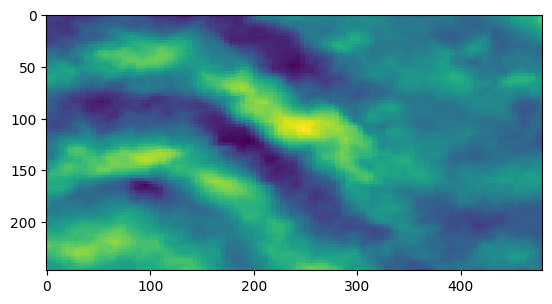

In [13]:
plt.imshow(ImgTS_total_day[0,:,:])

### multibands

In [43]:
def convert_bands_2_numpy(s2_sr_median, aoi_vineyard, scale):
    #using the median value of multi bands
    s2_sr_mediana = s2_sr_median.reproject(crs = ee.Projection('EPSG:4326'), scale=scale)

    #collect all the available bands over the aoi
    selected_bands = ["B1","B2", "B3","B4", "B5", "B6","B7","B8", "B9","B10","B11"]
    l8sr_bands = s2_sr_mediana.select(selected_bands).sampleRectangle(aoi_vineyard, defaultValue=0)

    band_arr = l8sr_bands.get('B1')
    s2_arr = np.array(band_arr.getInfo())

    #stack all bands together
    for idx, band in enumerate(selected_bands):
        if band == 'B1': continue
        band_arr = l8sr_bands.get(band)
        band_arr = np.array(band_arr.getInfo())
        # Stack the individual bands to make a 3-D array.
        s2_arr = np.dstack((s2_arr, band_arr))

    return s2_arr

def get_landsat_multispectral_image(aoi, i_date, f_date, scale):
    # Load a collection
    TERRA = (ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA')
              .filterDate(i_date, f_date)
              .filterBounds(aoi)  # Add this line to filter images containing AOI
              .sort('system:time_start')
              .median())

    arry3d = convert_bands_2_numpy(TERRA, aoi, scale)

    return arry3d

In [44]:
#input parameter
scale = 10
aoi = ee.Geometry.Polygon(
        [[[1.665586676010049, 48.55860495478288],
          [1.665586676010049, 48.536502067708305],
          [1.7085878509368069, 48.536502067708305],
          [1.7085878509368069, 48.55860495478288]]])

i_date, f_date = '2018-01-01', '2019-01-31'

#downloading multitempral band median image
arry3d = get_landsat_multispectral_image(aoi, i_date, f_date, scale)

In [45]:
arry3d.shape

(247, 479, 11)

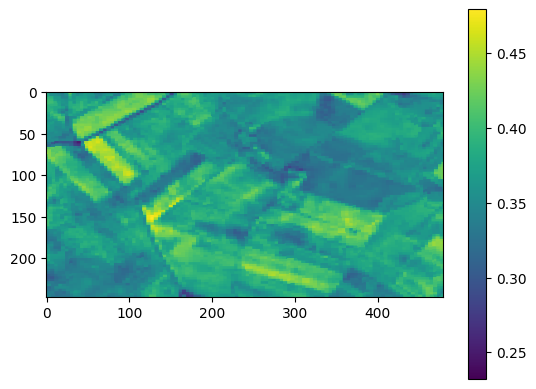

In [46]:
plt.imshow(arry3d[:,:,4])
plt.colorbar()